# HelloWo.. [CIFAR10](https://keras.io/datasets/)!
In this notebook, we will explore convolutional neural networks.

First, we load numpy and matplotlib as well as the keras layers we need.

In [1]:
# numpy and plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# keras
import keras
import tensorflow
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Softmax
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import metrics

###Load CIFAR10 dataset

We load the CIFAR10 dataset provided by keras, it contains 32x32-pixel images from ten classes.

In [2]:
from keras.datasets import cifar10
from keras import backend as K

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# maximum value normalization
x_train /= 255
x_test /= 255

num_classes = 10
batch_size = 128

170508288/170498071 [==============================] - 3s 0us/step

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In the next cell, we set reshape the dataset to have the color channels in the place the backend require. Tensorflow requires "channels_last".

We also convert the labels to one-hot-encoded labels.

In [3]:
# Convert class vectors to binary class matrices.
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

img_rows, img_cols, channels = x_train.shape[1:]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)

# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(K.image_data_format())
print(input_shape)
print(y_train[0])

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)
channels_last
(32, 32, 3)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [4]:
def predictCategorical(idx, model, data, preproc= None, cols=5):
    try:
        idx = list(idx)
    except:
        idx = [idx]
        
    data = data[idx]
        
    p = model.predict(data if preproc is None else preproc(data))
    
    ncats = 0
    ndogs = 0
    nother = 0
    
    i=0
    labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    while i < p.shape[0]:
        fig, axs = plt.subplots(1,cols,figsize=(5*cols,5))
        fig.figsize=(20,10)
        for ax in axs:
            ax.imshow(data[i])
            label = np.argsort(p[i])[-1]
            ax.text(.5,0, labels[label]+", score "+str(p[i][label]),
                    horizontalalignment='center', verticalalignment='bottom', transform=ax.axes.transAxes,
                    backgroundcolor="white", size="large")
            i += 1
            if i >= p.shape[0]:
                break
            
        plt.show()

##Baseline: Multi-Layer Perceptron (MLP)
To get a baseline, we try a multi-layer perceptron: A model with a few hidden dense layers. If there are enough of those (>~3), the model can be considered deep.

In [5]:
def makeMLP(hidden = [512,512,256], activation = 'relu', input_shape=input_shape, num_classes=num_classes):
    model = Sequential()
    
    # converts the images (32x32x3) into vectors
    model.add(Flatten(input_shape=input_shape))
    model.add(BatchNormalization())
    for a in hidden:
        model.add(Dense(a, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [6]:
model = makeMLP()
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= tensorflow.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 batch_normalization (BatchN  (None, 3072)             12288     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                        

Note, that this small MLP with three hidden layers of sizes 512, 512 and 256, already has about 2 million trainable parameters. The size of 512 activations is also not unreasonably large, as this already leads to a dimensional reduction of the input by a factor of 6.

In [7]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=20,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/20
391/391 [==============================] - 5s 5ms/step - loss: 2.4370 - accuracy: 0.1388 - val_loss: 2.2377 - val_accuracy: 0.1987
Epoch 2/20
391/391 [==============================] - 2s 4ms/step - loss: 2.1710 - accuracy: 0.2255 - val_loss: 2.0967 - val_accuracy: 0.2600
Epoch 3/20
391/391 [==============================] - 2s 4ms/step - loss: 2.0609 - accuracy: 0.2714 - val_loss: 2.0169 - val_accuracy: 0.2918
Epoch 4/20
391/391 [==============================] - 2s 4ms/step - loss: 1.9948 - accuracy: 0.2974 - val_loss: 1.9634 - val_accuracy: 0.3111
Epoch 5/20
391/391 [==============================] - 2s 4ms/step - loss: 1.9460 - accuracy: 0.3163 - val_loss: 1.9216 - val_accuracy: 0.3250
Epoch 6/20
391/391 [==============================] - 2s 4ms/step - loss: 1.9077 - accuracy: 0.3305 - val_loss: 1.8873 - val_accuracy: 0.3370
Epoch 7/20
391/391 [==============================] - 2s 4ms/step - loss: 1.8735 - accuracy: 0.3422 - val_loss: 1.8583 - val_accuracy: 0.3474
Epoch 

We can note down, that the validation accuray maxes out at about 53%. This is not nothing, as with ten classed, pure guessing would give an accuracy of 10%.

It also starts overfitting quite quickly. This could be mitigated by using data augmentation and more regularization to an extent, which could also inprove the generalization somewhat. But we want to focus on the comparison with convnets here and thus will keep the other aspects simple.

#Convolutional Neural Network
Let us no go to a very simple CNN. We compared to the previous MLP, we only replace the two larger hidden layers near the bottom by downsampling conv-layers.

In [8]:
def makeCNN1(filters = (32, 64), dense = (256,), kernel_size=(3,3), activation='relu'
            , input_shape=input_shape, num_classes=num_classes, normAfterConv=False):
    model = Sequential()
    
    # using input layer to set input size explicitly, before we loop over layers
    model.add(BatchNormalization(input_shape=input_shape))
    
    for a in filters:
        
        model.add(Conv2D(a, kernel_size=kernel_size, activation=activation, strides=(2,2)))
        if normAfterConv:
            model.add(BatchNormalization())
    
    model.add(Flatten())
    
    for a in dense:
        model.add(Dense(a, activation=activation))
    
    model.add(Dense(num_classes, activation='softmax'))
       
    return model

In [9]:
model = makeCNN1()
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 32, 32, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d (Conv2D)             (None, 15, 15, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               803072    
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                      

The concept of having conv layers 'looking' at the data and dense layers at the bottom interpreting the features found by the convolutional filters, has been used by early ImageNet-winning deep conv-nets.

Note, that this model only has ~825k trainable parameters, of which more than 800k are in the bottom dense layers.

In [10]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/10
391/391 [==============================] - 10s 5ms/step - loss: 2.3037 - accuracy: 0.1212 - val_loss: 2.2799 - val_accuracy: 0.1462
Epoch 2/10
391/391 [==============================] - 2s 4ms/step - loss: 2.2566 - accuracy: 0.1755 - val_loss: 2.2341 - val_accuracy: 0.1997
Epoch 3/10
391/391 [==============================] - 2s 4ms/step - loss: 2.2135 - accuracy: 0.2176 - val_loss: 2.1915 - val_accuracy: 0.2357
Epoch 4/10
391/391 [==============================] - 2s 4ms/step - loss: 2.1726 - accuracy: 0.2454 - val_loss: 2.1516 - val_accuracy: 0.2569
Epoch 5/10
391/391 [==============================] - 2s 4ms/step - loss: 2.1351 - accuracy: 0.2622 - val_loss: 2.1151 - val_accuracy: 0.2716
Epoch 6/10
391/391 [==============================] - 2s 4ms/step - loss: 2.1016 - accuracy: 0.2734 - val_loss: 2.0834 - val_accuracy: 0.2784
Epoch 7/10
391/391 [==============================] - 2s 4ms/step - loss: 2.0730 - accuracy: 0.2809 - val_loss: 2.0560 - val_accuracy: 0.2878
Epoch

This model already reaches a validation accuracy of ~65%, about 10% more than our MLP. It seems to be even more prone to overfitting, however. This could be improved by adding more regularization.
##Pure Convnet
Let us try an (almost) pure convnet next. Basically, we eliminate the hidden dense layers completely and only retain the dens output layer, which uses the feature map generated by the conv layers and produces the prediction. We add more conv layers to improve the models abstraction ability and to produce a smaller featuremap at the bottom, which controls the input size of the final dense layer.

In [11]:
model = makeCNN1((32,64,96,96),[], normAfterConv=True)
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=tensorflow.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 32, 32, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 32)        896       
                                                                 
 batch_normalization_3 (Batc  (None, 15, 15, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                                 
                                                      

In [12]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/10
391/391 [==============================] - 3s 7ms/step - loss: 2.9874 - accuracy: 0.1107 - val_loss: 2.6343 - val_accuracy: 0.1256
Epoch 2/10
391/391 [==============================] - 2s 6ms/step - loss: 2.8489 - accuracy: 0.1290 - val_loss: 2.7693 - val_accuracy: 0.1475
Epoch 3/10
391/391 [==============================] - 2s 6ms/step - loss: 2.7424 - accuracy: 0.1462 - val_loss: 2.6857 - val_accuracy: 0.1611
Epoch 4/10
391/391 [==============================] - 2s 6ms/step - loss: 2.6537 - accuracy: 0.1631 - val_loss: 2.6070 - val_accuracy: 0.1757
Epoch 5/10
391/391 [==============================] - 2s 6ms/step - loss: 2.5786 - accuracy: 0.1755 - val_loss: 2.5400 - val_accuracy: 0.1906
Epoch 6/10
391/391 [==============================] - 2s 6ms/step - loss: 2.5098 - accuracy: 0.1930 - val_loss: 2.4817 - val_accuracy: 0.2004
Epoch 7/10
391/391 [==============================] - 2s 6ms/step - loss: 2.4541 - accuracy: 0.2036 - val_loss: 2.4287 - val_accuracy: 0.2108
Epoch 

This mode is only marginally better, but note, that now we only need ~169k parameters to get the same result.

###Small Darknet
The previous CNNs took some inspiration from an architecture called darknet, which is used in the YOLO approach to object detection [https://pjreddie.com/darknet/yolo/] .

The inspired part is increasing the number of filters after downsamling, but there is more to the to that architecture. So let us try this correctly, but smaller.

In [13]:
def makeSmallDarknet(nunits=3, nfilters0=16, kernel_size=(3,3), activation='relu'
                     , input_shape=input_shape, num_classes=num_classes):
    model = Sequential()
    
    model.add(Conv2D(nfilters0, kernel_size=kernel_size, activation=activation
                     , input_shape=input_shape, padding="same"))
    
    for a in range(1,nunits+1):
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        nfilters = int(nfilters0*(2**a))
        for s in range(a//2):
            model.add(Conv2D(nfilters, kernel_size=kernel_size, activation=activation, padding="same"))
            model.add(Conv2D(nfilters//2, kernel_size=(1,1), activation=activation))
        model.add(Conv2D(nfilters, kernel_size=kernel_size, activation=activation, padding="same"))
        
    model.add(Conv2D(num_classes, kernel_size=(1,1), activation=activation))
    model.add(GlobalAveragePooling2D())
    model.add(Softmax())
    
    return model

In [14]:

model = makeSmallDarknet()
model.summary()

opt = tensorflow.keras.optimizers.Adam(lr=0.0001, decay=1e-6)

model.compile(loss=keras.losses.categorical_crossentropy,
              #optimizer=opt,
              optimizer=tensorflow.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 batch_normalization_7 (Batc  (None, 16, 16, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/10
391/391 [==============================] - 4s 8ms/step - loss: 2.3090 - accuracy: 0.1259 - val_loss: 2.3015 - val_accuracy: 0.1277
Epoch 2/10
391/391 [==============================] - 3s 8ms/step - loss: 2.2921 - accuracy: 0.1653 - val_loss: 2.2837 - val_accuracy: 0.1770
Epoch 3/10
391/391 [==============================] - 3s 7ms/step - loss: 2.2750 - accuracy: 0.1910 - val_loss: 2.2647 - val_accuracy: 0.2082
Epoch 4/10
391/391 [==============================] - 3s 7ms/step - loss: 2.2560 - accuracy: 0.2046 - val_loss: 2.2437 - val_accuracy: 0.2108
Epoch 5/10
391/391 [==============================] - 3s 7ms/step - loss: 2.2355 - accuracy: 0.2026 - val_loss: 2.2216 - val_accuracy: 0.2057
Epoch 6/10
391/391 [==============================] - 3s 7ms/step - loss: 2.2145 - accuracy: 0.1991 - val_loss: 2.1999 - val_accuracy: 0.2036
Epoch 7/10
391/391 [==============================] - 3s 7ms/step - loss: 2.1943 - accuracy: 0.1987 - val_loss: 2.1795 - val_accuracy: 0.2048
Epoch 

This model can us ~70% in validation accuracy, but since we are not augmenting the data here it also starts to overfit quickly.

Using data augmentation, it can reach >80%, but this takes a while.

In [16]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_generator = train_datagen.flow(x_train, y_train,
    batch_size=batch_size)

In [17]:
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=50000 // batch_size,
        epochs=50,
        validation_data=(x_test, y_test))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


390/390 [==============================] - 21s 54ms/step - loss: 2.1393 - accuracy: 0.2176 - val_loss: 2.1175 - val_accuracy: 0.2381
Epoch 2/50
390/390 [==============================] - 21s 54ms/step - loss: 2.1257 - accuracy: 0.2237 - val_loss: 2.1045 - val_accuracy: 0.2489
Epoch 3/50
390/390 [==============================] - 21s 55ms/step - loss: 2.1114 - accuracy: 0.2279 - val_loss: 2.0909 - val_accuracy: 0.2567
Epoch 4/50
390/390 [==============================] - 21s 55ms/step - loss: 2.0975 - accuracy: 0.2381 - val_loss: 2.0769 - val_accuracy: 0.2650
Epoch 5/50
390/390 [==============================] - 21s 53ms/step - loss: 2.0862 - accuracy: 0.2385 - val_loss: 2.0632 - val_accuracy: 0.2705
Epoch 6/50
390/390 [==============================] - 21s 53ms/step - loss: 2.0727 - accuracy: 0.2465 - val_loss: 2.0491 - val_accuracy: 0.2777
Epoch 7/50
390/390 [==============================] - 21s 53ms/step - loss: 2.0591 - accuracy: 0.2503 - val_loss: 2.0355 - val_accuracy: 0.2843
Epo

In [18]:
model.save_weights("darknet.h5")

##Getting and displaying the feature map


In [19]:
def makeSmallDarknetFkt(nunits=3, nfilters0=16, kernel_size=(3,3), activation='relu'
                     , input_shape=input_shape, num_classes=num_classes):
    model = Sequential()
    
    model.add(Conv2D(nfilters0, kernel_size=kernel_size, activation=activation
                     , input_shape=input_shape, padding="same"))
    
    for a in range(1,nunits+1):
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        nfilters = int(nfilters0*(2**a))
        for s in range(a//2):
            model.add(Conv2D(nfilters, kernel_size=kernel_size, activation=activation, padding="same"))
            model.add(Conv2D(nfilters//2, kernel_size=(1,1), activation=activation))
        model.add(Conv2D(nfilters, kernel_size=kernel_size, activation=activation, padding="same"))
    
    model.add(Conv2D(num_classes, kernel_size=(1,1), activation=activation))
    modelTop = Sequential()
    modelTop.add(GlobalAveragePooling2D(input_shape=model.output_shape[1:]))
    modelTop.add(Softmax())
    
    modelFull = Model(inputs=model.input, 
              outputs=modelTop(model.output))
    
    return modelFull, model

In [20]:
modelF, modelM = makeSmallDarknetFkt()
modelF.summary()

opt = tensorflow.keras.optimizers.Adam(lr=0.01, decay=1e-6)

modelF.compile(loss=keras.losses.categorical_crossentropy,
              #optimizer=opt,
              optimizer=tensorflow.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15_input (InputLayer  [(None, 32, 32, 3)]      0         
 )                                                               
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 16, 16, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 32)        4640      
                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:

hist = modelF.fit_generator(
        train_generator,
        steps_per_epoch=50000 // batch_size,
        epochs=10,
        validation_data=(x_test, y_test))

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


390/390 [==============================] - 21s 52ms/step - loss: 2.3041 - accuracy: 0.0960 - val_loss: 2.3038 - val_accuracy: 0.0980
Epoch 2/10
390/390 [==============================] - 20s 51ms/step - loss: 2.2942 - accuracy: 0.1118 - val_loss: 2.2873 - val_accuracy: 0.1358
Epoch 3/10
390/390 [==============================] - 20s 51ms/step - loss: 2.2847 - accuracy: 0.1397 - val_loss: 2.2751 - val_accuracy: 0.1410
Epoch 4/10
390/390 [==============================] - 20s 51ms/step - loss: 2.2747 - accuracy: 0.1493 - val_loss: 2.2631 - val_accuracy: 0.1405
Epoch 5/10
390/390 [==============================] - 20s 52ms/step - loss: 2.2626 - accuracy: 0.1538 - val_loss: 2.2490 - val_accuracy: 0.1439
Epoch 6/10
390/390 [==============================] - 20s 51ms/step - loss: 2.2482 - accuracy: 0.1641 - val_loss: 2.2325 - val_accuracy: 0.1553
Epoch 7/10
390/390 [==============================] - 20s 51ms/step - loss: 2.2306 - accuracy: 0.1757 - val_loss: 2.2123 - val_accuracy: 0.1719
Epo

In [22]:
modelF.load_weights("darknet.h5")


In [23]:
def showMaps(idx, model, data, preproc= None, cols=5):
    try:
        idx = list(idx)
    except:
        idx = [idx]
        
    data = data[idx]
        
    p = model[0].predict(data if preproc is None else preproc(data))
    m = model[1].predict(data if preproc is None else preproc(data))
    m = np.argmax(m, axis=3)
    print(m.shape)
    
    ncats = 0
    ndogs = 0
    nother = 0
    
    i=0
    labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    while i < p.shape[0]:
        fig, axs = plt.subplots(2,cols,figsize=(5*cols,5))
        fig.figsize=(20,10)
        for ax, axM in zip(axs[0], axs[1]):
            ax.imshow(data[i])
            axM.imshow(m[i],vmin=0, vmax=len(labels)-1, interpolation="none")
            label = np.argsort(p[i])[-1]
            ax.text(.5,0, labels[label]+", score "+str(p[i][label]),
                    horizontalalignment='center', verticalalignment='bottom', transform=ax.axes.transAxes,
                    backgroundcolor="white", size="large")
            i += 1
            if i >= p.shape[0]:
                break
            
        plt.show()

(20, 4, 4)


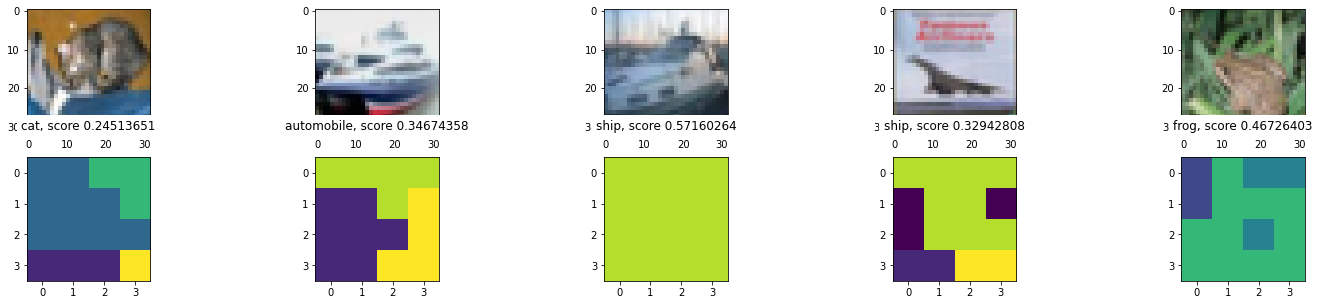

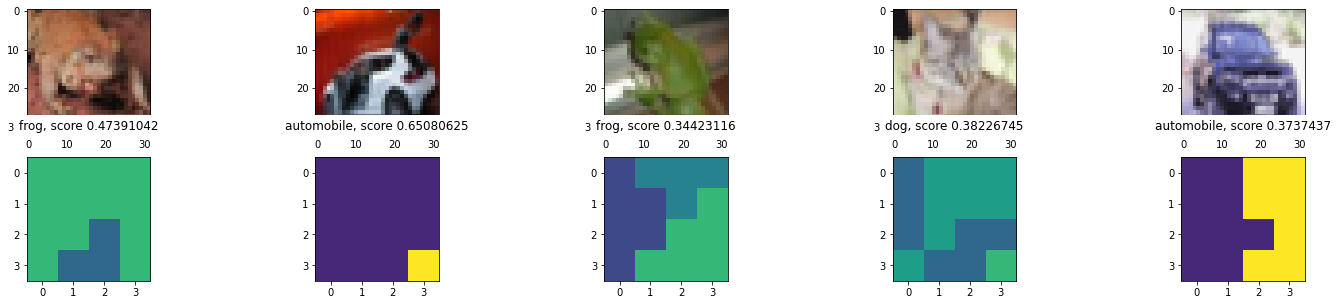

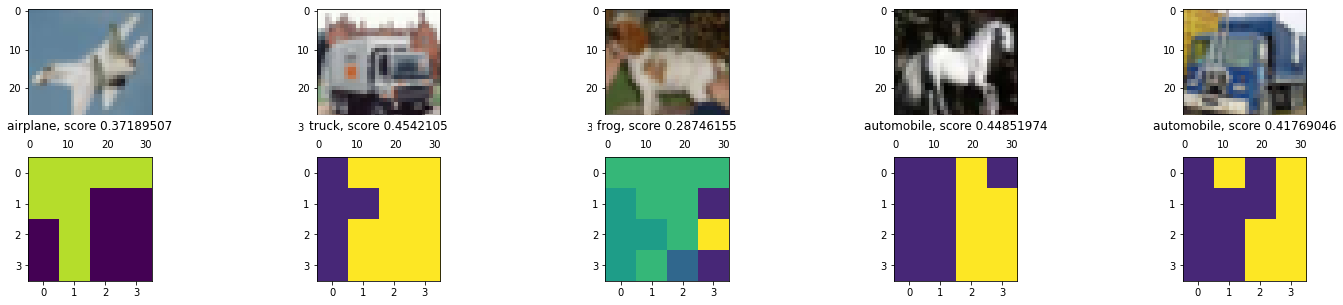

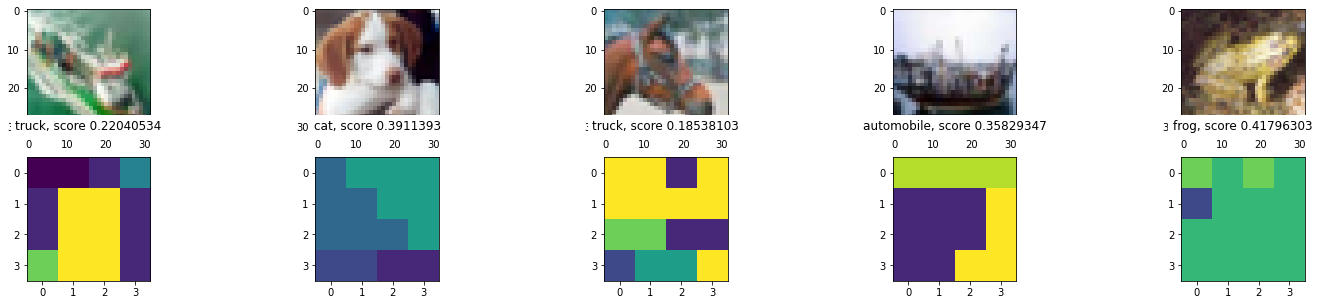

In [24]:
showMaps(range(20), (modelF,modelM), x_test)